In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset

from torchvision import datasets, models, utils, transforms
from torchvision import transforms as T
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import torchsummary

from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
np.random.seed(0)
torch.manual_seed(0)
%matplotlib inline
sns.set_style('darkgrid')

In [6]:
data_transforms = {
    "train": transforms.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()]),
    "test": transforms.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()]),
}

In [21]:
data_dir = '../polyp_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cpu")

In [8]:
idx2class = {v: k for k, v in image_datasets['train'].class_to_idx.items()}
idx2class


{0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}

Text(0.5, 1.0, 'Entire Dataset (before train/val/test split)')

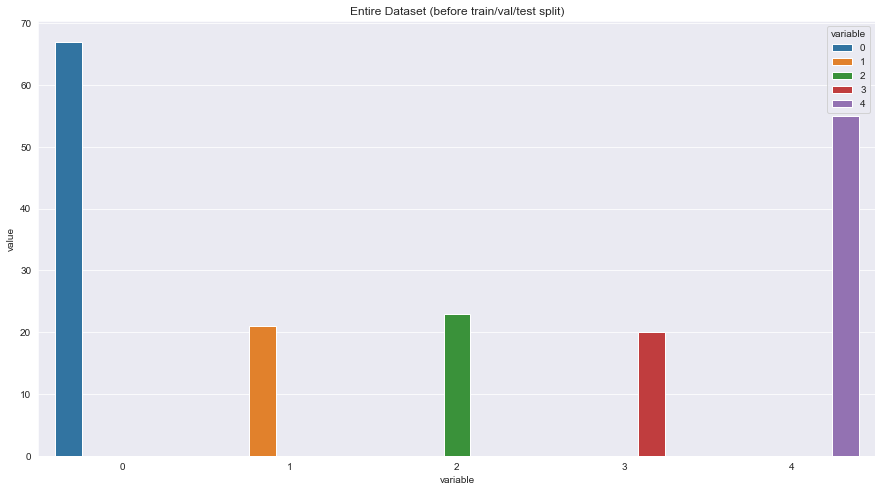

In [9]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict

def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)


plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(image_datasets['train']),plot_title="Entire Dataset (before train/val/test split)")

In [18]:
import random
import numpy as np
import os
import cv2
import glob
from PIL import Image
import PIL.ImageOps    

#다음 변수를 수정하여 새로 만들 이미지 갯수를 정합니다.
num_augmented_images = 30

file_path = '../polyp_data/train/3/'
save_path = '../polyp_data/train/3/'
file_names = os.listdir(file_path)
total_origin_image_num = len(file_names)
augment_cnt = 1

for i in range(1, num_augmented_images):
    change_picture_index = random.randrange(1, total_origin_image_num-1)
    print(change_picture_index)
    print(file_names[change_picture_index])
    file_name = file_names[change_picture_index]
    
    origin_image_path = '../polyp_data/train/3/' + file_name
    print(origin_image_path)
    image = Image.open(origin_image_path)
    random_augment = random.randrange(1,3)
    
    if(random_augment == 1):
        #이미지 좌우 반전
        print("invert")
        inverted_image = image.transpose(Image.FLIP_LEFT_RIGHT)
        inverted_image.save(save_path + 'inverted_' + str(augment_cnt) + '.png')
    
    else:
        #이미지 기울이기
        print("rotate")
        rotated_image = image.rotate(random.randrange(-20, 20))
        rotated_image.save(save_path + 'rotated_' + str(augment_cnt) + '.png')
        
        
    augment_cnt += 1

4
At_257_김-3.jpg
../polyp_data/train/3/At_257_김-3.jpg
invert
14
At_371_유-4.jpg
../polyp_data/train/3/At_371_유-4.jpg
rotate
8
At_294_김-4.jpg
../polyp_data/train/3/At_294_김-4.jpg
rotate
10
At_314_윤-2.jpg
../polyp_data/train/3/At_314_윤-2.jpg
rotate
16
At_371_유-6.jpg
../polyp_data/train/3/At_371_유-6.jpg
rotate
12
At_371_유-2.jpg
../polyp_data/train/3/At_371_유-2.jpg
invert
3
At_257_김-2.jpg
../polyp_data/train/3/At_257_김-2.jpg
rotate
2
At_257_김-1.jpg
../polyp_data/train/3/At_257_김-1.jpg
rotate
15
At_371_유-5.jpg
../polyp_data/train/3/At_371_유-5.jpg
rotate
13
At_371_유-3.jpg
../polyp_data/train/3/At_371_유-3.jpg
rotate
14
At_371_유-4.jpg
../polyp_data/train/3/At_371_유-4.jpg
invert
15
At_371_유-5.jpg
../polyp_data/train/3/At_371_유-5.jpg
invert
7
At_294_김-3.jpg
../polyp_data/train/3/At_294_김-3.jpg
rotate
16
At_371_유-6.jpg
../polyp_data/train/3/At_371_유-6.jpg
rotate
16
At_371_유-6.jpg
../polyp_data/train/3/At_371_유-6.jpg
invert
14
At_371_유-4.jpg
../polyp_data/train/3/At_371_유-4.jpg
rotate
6
At_294_김-2.

Text(0.5, 1.0, 'Entire Dataset (before train/val/test split)')

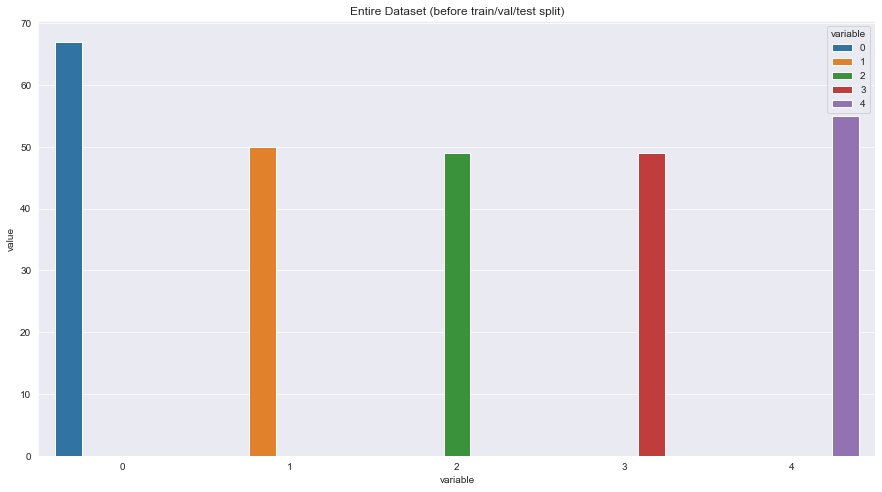

In [22]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict

def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)

plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(image_datasets['train']),plot_title="Entire Dataset (before train/val/test split)")

In [23]:
image_dataset_size = len(image_datasets['train'])
image_dataset_indices = list(range(image_dataset_size))

In [24]:
np.random.shuffle(image_dataset_indices)

In [25]:
val_split_index = int(np.floor(0.2 * image_dataset_size))

In [26]:
train_idx, val_idx = image_dataset_indices[val_split_index:], image_dataset_indices[:val_split_index]

In [27]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [28]:
train_loader = DataLoader(dataset=image_datasets['train'], shuffle=False, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset=image_datasets['train'], shuffle=False, batch_size=1, sampler=val_sampler)
test_loader = DataLoader(dataset=image_datasets['test'], shuffle=False, batch_size=1)

In [29]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:    
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else: 
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict

Text(0.5, 1.0, 'Val Set')

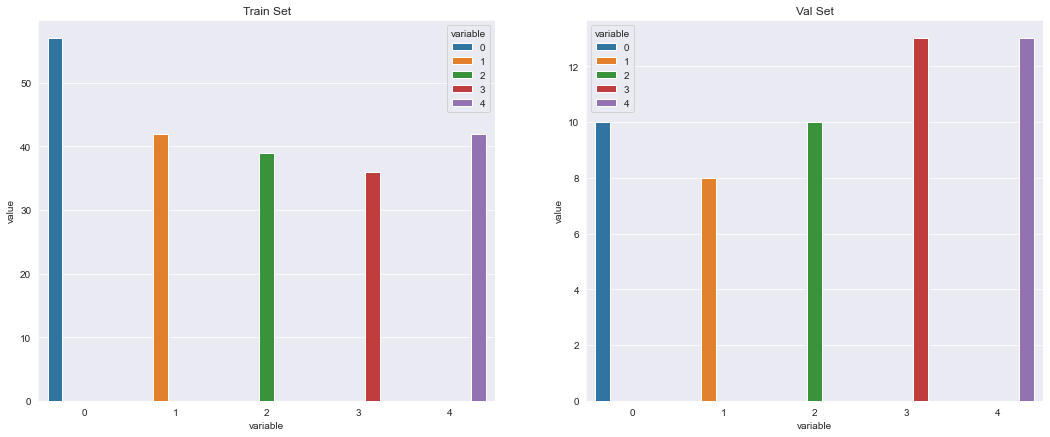

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
plot_from_dict(get_class_distribution_loaders(train_loader, image_datasets['train']), plot_title="Train Set", ax=axes[0])
plot_from_dict(get_class_distribution_loaders(val_loader, image_datasets['train']), plot_title="Val Set", ax=axes[1])

Output label tensors:  tensor([1, 0, 1, 4, 3, 1, 1, 1])

Output label tensor shape:  torch.Size([8])


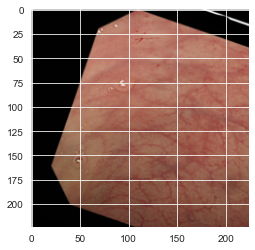

In [31]:
single_batch = next(iter(train_loader))
single_batch[0].shape
print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)

# Selecting the first image tensor from the batch. 
single_image = single_batch[0][0]
single_image.shape
plt.imshow(single_image.permute(1, 2, 0))

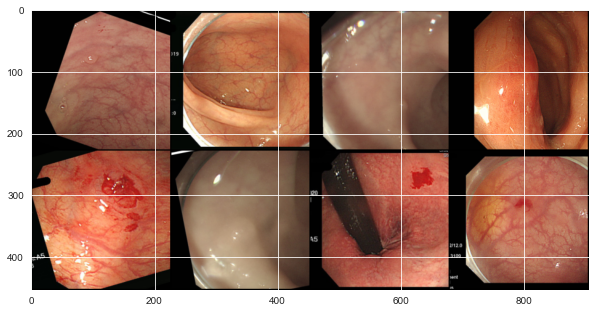

In [32]:
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))

In [33]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

In [34]:
model = resnet18
model.to(device)
#print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [35]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

In [36]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [37]:
print("Begin training.")
for e in tqdm(range(1, 101)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch).squeeze()
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 01: | Train Loss: 3.45769 | Val Loss: 2.17917 | Train Acc: 24.963| Val Acc: 12.000
Epoch 02: | Train Loss: 1.69468 | Val Loss: 1.90426 | Train Acc: 30.519| Val Acc: 25.000
Epoch 03: | Train Loss: 1.59456 | Val Loss: 1.41011 | Train Acc: 35.222| Val Acc: 38.000
Epoch 04: | Train Loss: 1.65500 | Val Loss: 1.58293 | Train Acc: 36.074| Val Acc: 50.000
Epoch 05: | Train Loss: 1.57205 | Val Loss: 1.21654 | Train Acc: 43.519| Val Acc: 38.000
Epoch 06: | Train Loss: 1.61735 | Val Loss: 1.65528 | Train Acc: 31.630| Val Acc: 38.000
Epoch 07: | Train Loss: 1.51697 | Val Loss: 0.71515 | Train Acc: 44.481| Val Acc: 50.000
Epoch 08: | Train Loss: 1.27577 | Val Loss: 2.02655 | Train Acc: 50.519| Val Acc: 25.000
Epoch 09: | Train Loss: 1.36047 | Val Loss: 1.54176 | Train Acc: 46.296| Val Acc: 38.000
Epoch 10: | Train Loss: 1.53266 | Val Loss: 1.08433 | Train Acc: 40.741| Val Acc: 75.000
Epoch 11: | Train Loss: 1.29091 | Val Loss: 0.72971 | Train Acc: 48.519| Val Acc: 75.000
Epoch 12: | Train Los

Epoch 93: | Train Loss: 0.13651 | Val Loss: 0.00395 | Train Acc: 95.037| Val Acc: 100.000
Epoch 94: | Train Loss: 0.29718 | Val Loss: 1.76918 | Train Acc: 92.222| Val Acc: 75.000
Epoch 95: | Train Loss: 0.25098 | Val Loss: 0.00569 | Train Acc: 92.778| Val Acc: 100.000
Epoch 96: | Train Loss: 0.10203 | Val Loss: 0.13038 | Train Acc: 97.296| Val Acc: 100.000
Epoch 97: | Train Loss: 0.07794 | Val Loss: 0.01622 | Train Acc: 96.889| Val Acc: 100.000
Epoch 98: | Train Loss: 0.05779 | Val Loss: 0.01981 | Train Acc: 98.222| Val Acc: 100.000
Epoch 99: | Train Loss: 0.08084 | Val Loss: 0.13101 | Train Acc: 97.333| Val Acc: 88.000
Epoch 100: | Train Loss: 0.03667 | Val Loss: 0.05802 | Train Acc: 99.556| Val Acc: 100.000



Text(0.5, 1.0, 'Train-Val Loss/Epoch')

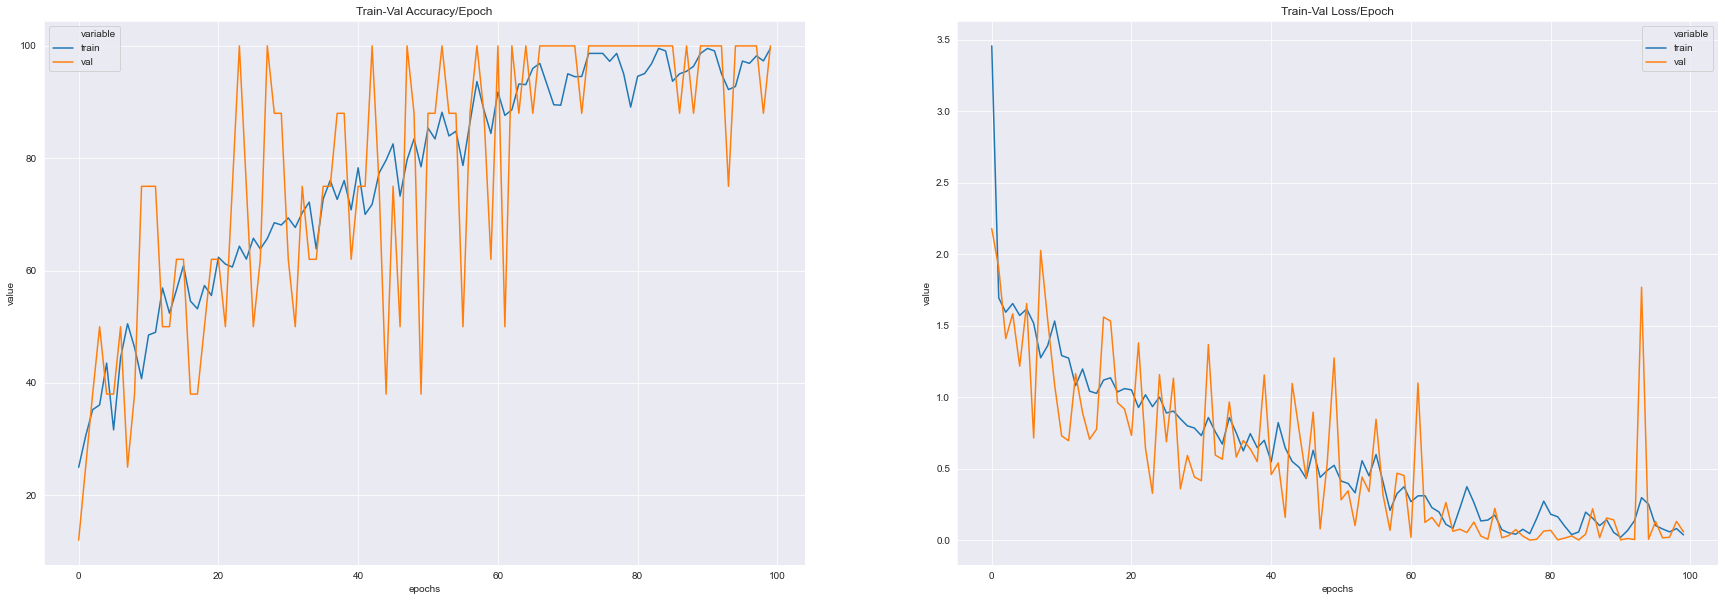

In [38]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot line charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [39]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [40]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.39      0.30      0.34        30
           1       0.80      0.89      0.84         9
           2       1.00      0.44      0.62         9
           3       0.36      0.44      0.40         9
           4       0.42      0.58      0.49        24

    accuracy                           0.48        81
   macro avg       0.60      0.53      0.54        81
weighted avg       0.51      0.48      0.48        81



In [41]:
print(confusion_matrix(y_true_list, y_pred_list))

[[ 9  1  0  1 19]
 [ 0  8  0  1  0]
 [ 0  0  4  5  0]
 [ 5  0  0  4  0]
 [ 9  1  0  0 14]]


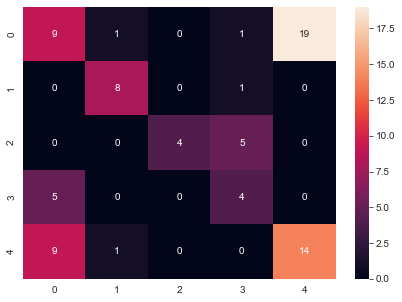

In [42]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)